# Football in Denmark: Where are we playing?

Imports and set magics:

In [1]:
# %pip install git+https://github.com/alemartinello/dstapi #Installing the API (only need to do once)

In [2]:
# %pip install pandas-datareader # Installing the data reader (only need to do once)

In [3]:
# %pip install geopandas 
# Installing the geopandas reader (only need to do once)

In [4]:
import pandas as pd
from IPython.display import Image
import numpy as np
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import ipywidgets as widgets
# from matplotlib_venn import venn2
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read data

Creating a dictionary for the columns names:

In [5]:
columns_dict = {}
columns_dict['BLSTKOM'] = 'region'
columns_dict['AKTIVITET'] = 'activity'
columns_dict['KON'] = 'sex'
columns_dict['ALDER1'] = 'age'
columns_dict['TID'] = 'year'
columns_dict['POP'] = 'population'
columns_dict['INDHOLD'] = 'players'

**Step 1:** Downloading all of the football-variables in merged_df01

In [6]:
idrakt_api = DstApi('IDRAKT01')  #Creating the DST API which will allow us to interact with the API server
params = idrakt_api._define_base_params(language='en') #Creating a parameter dictionary with the language set to English
variables = params['variables'] # Returns a view, that we can edit
variables[1]['values'] = ['A22'] # Choosing football as the activity (The ID for football is A22 Using code from: https://alemartinello.com/2022/02/24/dstapi/)
print(variables)

[{'code': 'BLSTKOM', 'values': ['*']}, {'code': 'AKTIVITET', 'values': ['A22']}, {'code': 'KON', 'values': ['*']}, {'code': 'ALDER1', 'values': ['*']}, {'code': 'Tid', 'values': ['*']}]


In [7]:
idrakt = idrakt_api.get_data(params=params) #Downloading the dataset

**Step 1A** Henter Befolkningsdata fra FOLK1AM

In [8]:
folk_api = DstApi('FOLK1A')  #Creating the DST API which will allow us to interact with the API server
params = folk_api._define_base_params(language='en') #Creating a parameter dictionary with the language set to English
variables = params['variables'] # Returns a view, that we can edit
variables[2]['values'] = ['IALT']
variables[3]['values'] = ['TOT']
print(variables)

[{'code': 'OMRÅDE', 'values': ['*']}, {'code': 'KØN', 'values': ['*']}, {'code': 'ALDER', 'values': ['IALT']}, {'code': 'CIVILSTAND', 'values': ['TOT']}, {'code': 'Tid', 'values': ['*']}]


In [9]:
folk = folk_api.get_data(params=params) #Downloading the dataset

# Clean data

**Cleaning population data (FOLK1A)**

In [10]:
folk.drop(columns=['ALDER', 'CIVILSTAND'], inplace=True)

In [11]:
folk_q1 = folk.loc[folk['TID'].str.contains('Q1')] # Selecting only the first quarter of the year
folk_q1['TID'] = folk_q1['TID'].str.replace('Q1', '')
folk_q1['KØN'] = folk_q1['KØN'].str.replace('Total', 'Sex, total')
folk_q1['OMRÅDE'] = folk_q1['OMRÅDE'].str.replace('Landsdel', 'Province')

# Define a list of the regions in the dataset
regions = ['All Denmark', 'Region Nordjylland', 'Region Midtjylland', 'Region Syddanmark', 'Region Sjælland', 'Region Hovedstaden']

# Filter the DataFrame to keep only rows where 'OMRÅDE' matches one of the regions
folk_q1 = folk_q1[folk_q1['OMRÅDE'].isin(regions)]
folk_q1.head()

/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_71852/3082106661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folk_q1['TID'] = folk_q1['TID'].str.replace('Q1', '')
/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_71852/3082106661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folk_q1['KØN'] = folk_q1['KØN'].str.replace('Total', 'Sex, total')
/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_71852/3082106661.py:4: SettingWithCopyWarning: 
A value is trying to be set 

,OMRÅDE,KØN,TID,INDHOLD
50,Region Sjælland,Men,2009,407228
56,Region Sjælland,"Sex, total",2009,821252
61,Region Sjælland,Women,2009,414024
262,Region Syddanmark,"Sex, total",2009,1199667
263,Region Syddanmark,Men,2009,597320


**Cleaning football data (IDRAKT01)**

**Step 2:** Only keep rows where the variable is in `Age, total` and afterwards deleting the coloumn.

In [12]:
#Only keeps rows with age = 'Age, total' and afterwards deleting the age coloumn
idrakt = idrakt[idrakt['ALDER1'] == 'Age, total']
idrakt.drop(columns=['ALDER1'],inplace=True)

Summarizing provinces to regions:

In [13]:
def map_regions(BLSTKOM):
    if BLSTKOM == 'All Denmark':
        return 'All Denmark'
    elif BLSTKOM == 'Province Nordjylland':
        return 'Region Nordjylland'
    elif BLSTKOM in ['Province Vestjylland', 'Province Østjylland']:
        return 'Region Midtjylland'
    elif BLSTKOM in ['Province Fyn', 'Province Sydjylland']:
        return 'Region Syddanmark'
    elif BLSTKOM in ['Province Østsjælland', 'Province Vest- og Sydsjælland']:
        return 'Region Sjælland'
    elif BLSTKOM in ['Province Bornholm', 'Province Byen København', 'Province Københavns omegn', 'Province Nordsjælland']:
        return 'Region Hovedstaden'
    else:
        return BLSTKOM  # Keep the original value for non-province entries

# Apply the function and update the 'BLSTKOM' column in place
idrakt['BLSTKOM'] = idrakt['BLSTKOM'].apply(map_regions)

Only keeping regions and all of Denmark

In [14]:
# Filter the DataFrame to keep only rows where 'BLSTKOM' matches one of the regions
idrakt = idrakt[idrakt['BLSTKOM'].isin(regions)]

# Display the first few rows to verify the filtering
idrakt.head()

,BLSTKOM,AKTIVITET,KON,TID,INDHOLD
180,Region Nordjylland,Football,Men,2019,30800
186,Region Nordjylland,Football,"Sex, total",2019,40140
192,Region Nordjylland,Football,Women,2019,9340
288,Region Hovedstaden,Football,Men,2017,43840
294,Region Hovedstaden,Football,"Sex, total",2017,49680


## Merging the two datasets and the sorting:

In [16]:
idrakt['TID'] = idrakt['TID'].astype(str)
folk_q1['TID'] = folk_q1['TID'].astype(str)

consolidated_df = pd.merge(
    idrakt,
    folk_q1.rename(columns={'INDHOLD': 'POP'}),  # Rename INDHOLD to POP in folk_q1 before merging
    how='left',  # Keep all rows from idrakt
    left_on=['BLSTKOM', 'KON', 'TID'],  # Columns to match in idrakt
    right_on=['OMRÅDE', 'KØN', 'TID']  # Corresponding columns to match in folk_q1
)
consolidated_df.drop(['OMRÅDE', 'KØN'], axis=1, inplace=True) #Drops unnessecary columns

# rename columns
consolidated_df.rename(columns=columns_dict,inplace=True)

#We need to add across provinces within the regions
def first_value(series):
    return series.iloc[0]

merged_df = consolidated_df.groupby(['region', 'sex', 'year']).agg({'players': 'sum', 'population': first_value}).reset_index()



Sort the dataset by region, year and sex

In [17]:
# Sorting the dataset by county then year and then total sex, but first we customly sort the order of Sex
# Define a custom sorting order
sort_order = ['Sex, total', 'Men', 'Women']

# Create a categorical type with the custom order
merged_df['sex'] = pd.Categorical(merged_df['sex'], categories=sort_order, ordered=True)

merged_df.sort_values(by=['region','year','sex'],inplace=True)
merged_df.reset_index(drop=True,inplace=True)
merged_df.head()

,region,sex,year,players,population
0,All Denmark,"Sex, total",2014,374400,5627235
1,All Denmark,Men,2014,307430,2792279
2,All Denmark,Women,2014,66970,2834956
3,All Denmark,"Sex, total",2015,372640,5659715
4,All Denmark,Men,2015,306540,2811014


# Analysis across genders

Here we calculate the total number of Danish football players split based on sex. We have made the graph in the py-file as total_players_dk.

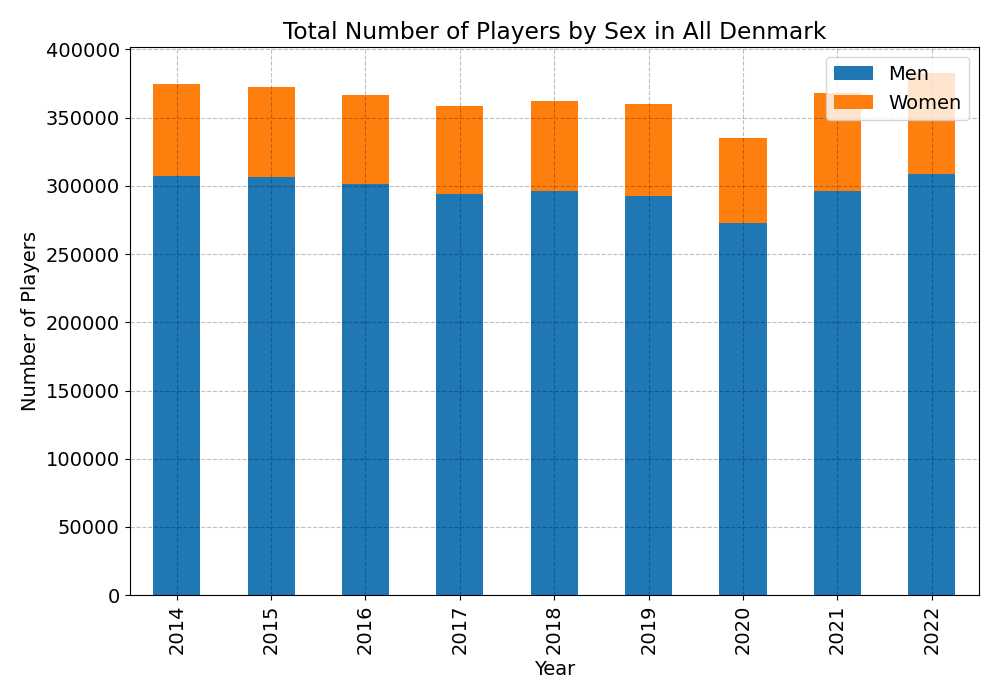

In [18]:
from dataproject import total_players_dk
total_players_dk(merged_df)
# Display the saved plot in the notebook
Image(filename='stacked_bar_chart.png')

It is hard to see the relative development between the sexes and for total. Hence, we index the values and display here.

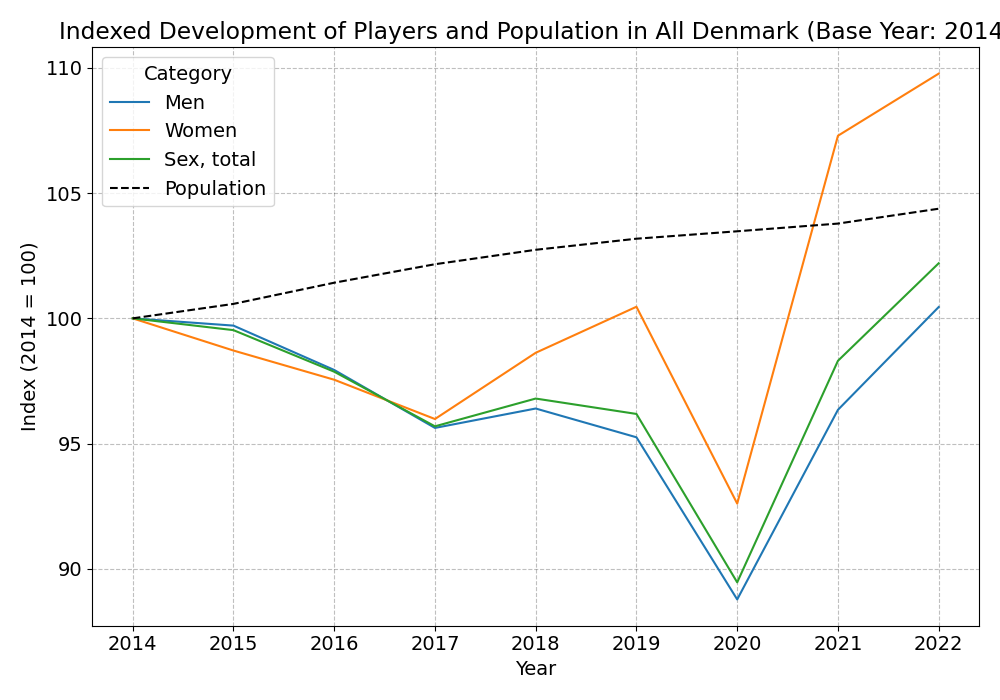

In [19]:
# Assuming df is your DataFrame and you call this function in your Jupyter Notebook
from dataproject import index_players_dk
index_players_dk(merged_df)
Image(filename='indexed_players_chart.png')

2018 women suddenly increases a lot towards 2019. The lockdown in 2020 is visuably for both sexes. However, afterwards, women footballers continues to increase with a much higher rate than men. Actually we see, that the increase in football players does not at all correspond to the increment in population. That could have something to do with the fact, that we look at total population, and not the population in the age group 6-60 years (the age group, where most football players are).

**Annual growth contributions**

/Users/frederiknordentoft/Documents/GitHub/projects-2024-econtechvets/dataproject/dataproject.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dk['year_over_year_change'] = df_dk.groupby('sex')['players'].diff()
/Users/frederiknordentoft/Documents/GitHub/projects-2024-econtechvets/dataproject/dataproject.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk['year_over_year_change'] = df_dk.groupby('sex')['players'].diff()


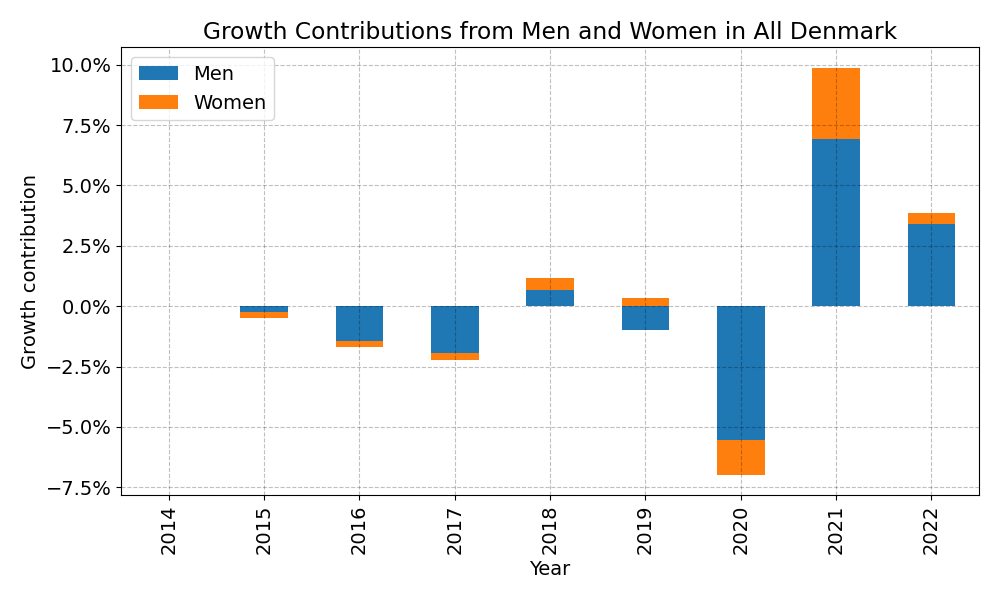

In [20]:
from dataproject import plot_growth_contributions_all_denmark
plot_growth_contributions_all_denmark(merged_df)
# Display the saved plot
Image(filename='growth_contributions_all_denmark.png')

The figure above shows that even though women increases a lot, the contributions to the overall growth is fairly dominated by men because of the larger base. 

# Analysis across geography

Plotting the number of football players by region in an interactive graph. 

Click the names in the legend to hide/show the data for a specific region or All Denmark.

In [21]:
# Load and prepare the DataFrame
from dataproject import index_players_by_region, plot_indexed_players
indexed_df = index_players_by_region(merged_df)

# Define an interactive widget to select regions and display the plot
regions = indexed_df['region'].unique()

@widgets.interact
def display_plot(selected_regions=widgets.SelectMultiple(options=regions, value=[regions[0]], description='Regions')):
    plot_indexed_players(indexed_df, selected_regions)

Comment: The graph shows how just two Regions are increasing in 2022 compared to 2014, i.e. Region Hovedstaden and Region Nordjylland. The other regions are decreasing or stagnating. However, the tendency across regions are the same as All Denmark. 

**Making a plot of the share of players in each region compared to the population in the given region.**

The plot as well is interactive. Click the names in the legend to hide/show the data for a specific region or All Denmark.

In [22]:
from dataproject import calculate_player_share, plot_share_data

# Calculate the share of players in population
processed_df = calculate_player_share(merged_df)

# Plot the data
plot_share_data(processed_df)

Making a plot of the sexes across counties

# Conclusion

ADD CONCISE CONLUSION.

We see that...